In [1]:
# 1. IMPOR PUSTAKA YANG DIBUTUHKAN
import os

# Mengatur environment variable untuk menyembunyikan log TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Mengatur agar pesan log Python juga tidak terlalu ramai
import logging
tf.get_logger().setLevel(logging.ERROR)


# 2. PERSIAPAN DIREKTORI
print("🚀 Membuat direktori untuk Kasus D...")

# Membuat folder-folder baru untuk menyimpan semua hasil dari kasus ini
os.makedirs("saved_models_kasus_d", exist_ok=True)
os.makedirs("tflite_models_kasus_d_float", exist_ok=True)
os.makedirs("tflite_models_kasus_d_int8", exist_ok=True)
os.makedirs("headers_kasus_d_float", exist_ok=True)
os.makedirs("headers_kasus_d_int8", exist_ok=True)

print("✅ Direktori siap.")

🚀 Membuat direktori untuk Kasus D...
✅ Direktori siap.


In [2]:
# 3. MEMUAT DAN MEMPROSES DATA
print("🚀 Memuat iris_extended.csv dan memproses fitur...")

# Memuat dataset dari file
df = pd.read_csv('iris_extended.csv')

# === Pisahkan fitur (X) dan target (y) ===
# Gunakan semua fitur numerik (drop kolom kategori)
X_raw = df.drop(columns=['species', 'soil_type'])
y_raw = df['species']

# === Encoding target ===
# Ubah label teks (setosa, versicolor, virginica) → angka (0,1,2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

# Ubah menjadi One-Hot Encoding → [1,0,0], [0,1,0], [0,0,1]
num_classes = len(label_encoder.classes_)
y = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

# === PEMBAGIAN DATA (belum scaling) ===
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X_raw, y, test_size=0.10, random_state=42, stratify=y
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.111, random_state=42, stratify=y_train_val
)

# === Scaling fitur numerik ===
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val   = scaler.transform(x_val)
x_test  = scaler.transform(x_test)

# === Info akhir ===
print("✅ Data berhasil diproses & dibagi:")
print(f"   Bentuk x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"   Bentuk x_val:   {x_val.shape}, y_val:   {y_val.shape}")
print(f"   Bentuk x_test:  {x_test.shape}, y_test: {y_test.shape}")
print(f"   Jumlah fitur: {x_train.shape[1]}, Jumlah kelas: {num_classes}")

🚀 Memuat iris_extended.csv dan memproses fitur...
✅ Data berhasil diproses & dibagi:
   Bentuk x_train: (960, 19), y_train: (960, 3)
   Bentuk x_val:   (120, 19), y_val:   (120, 3)
   Bentuk x_test:  (120, 19), y_test: (120, 3)
   Jumlah fitur: 19, Jumlah kelas: 3


In [3]:
# 4. TRAINING, EVALUASI, DAN PENGUMPULAN HASIL
model_configs = [(1, 8), (2, 16), (3, 32), (4, 64)]

# List untuk menyimpan semua data hasil
all_train_loss_histories, all_val_loss_histories = [], []
all_best_val_losses, all_test_losses = [], []
all_best_val_accuracies, all_test_accuracies = [], []
all_precisions, all_recalls, all_f1s = [], [], []
all_best_epochs = []
model_labels = []

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

print("\n🚀 Memulai training semua model Multikelas (Dengan Early Stopping)...\n")
for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    print(f"--- Memproses Model {idx} ({num_layers}L, {neurons}N) ---")
    
    # Buat model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(x_train.shape[1],)))
    
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
        
    # Output untuk multikelas → softmax
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Latih model
    history = model.fit(
        x_train, y_train,
        epochs=200,
        validation_data=(x_val, y_val),
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Simpan model
    model_path = f"saved_models_kasus_d/model_{idx}_{num_layers}L_{neurons}N.keras"
    model.save(model_path)

    # Cari epoch terbaik (berdasarkan val_loss)
    best_epoch_index = np.argmin(history.history['val_loss'])
    all_train_loss_histories.append(history.history['loss'])
    all_val_loss_histories.append(history.history['val_loss'])
    all_best_epochs.append(best_epoch_index + 1)
    
    # Evaluasi di val & test
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    
    # Prediksi untuk hitung precision, recall, f1
    y_pred_prob = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1        = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Simpan hasil
    all_best_val_losses.append(val_loss)
    all_best_val_accuracies.append(val_acc)
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_acc)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    
    model_labels.append(f"Model {idx}\n({num_layers}L, {neurons}N)")
    
    # Ringkasan
    print(f"  Akurasi Validasi: {val_acc*100:.2f}%")
    print(f"  Akurasi Test:     {test_acc*100:.2f}%")
    print(f"  Precision (W):    {precision*100:.2f}%")
    print(f"  Recall (W):       {recall*100:.2f}%")
    print(f"  F1-Score (W):     {f1*100:.2f}%")
    print(f"  Loss Test:        {test_loss:.4f}")
    print("-" * 50)

print("\n🏁 Pengumpulan Data Selesai.\n")


🚀 Memulai training semua model Multikelas (Dengan Early Stopping)...

--- Memproses Model 1 (1L, 8N) ---
Epoch 144: early stopping
Restoring model weights from the end of the best epoch: 114.
  Akurasi Validasi: 99.17%
  Akurasi Test:     99.17%
  Precision (W):    99.19%
  Recall (W):       99.17%
  F1-Score (W):     99.17%
  Loss Test:        0.0185
--------------------------------------------------
--- Memproses Model 2 (2L, 16N) ---
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 50.
  Akurasi Validasi: 100.00%
  Akurasi Test:     99.17%
  Precision (W):    99.19%
  Recall (W):       99.17%
  F1-Score (W):     99.17%
  Loss Test:        0.0184
--------------------------------------------------
--- Memproses Model 3 (3L, 32N) ---
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 25.
  Akurasi Validasi: 100.00%
  Akurasi Test:     99.17%
  Precision (W):    99.19%
  Recall (W):       99.17%
  F1-Score (W):     99.17%
  


📊 Membuat 5 plot terpisah untuk menganalisis hasil Kasus D...



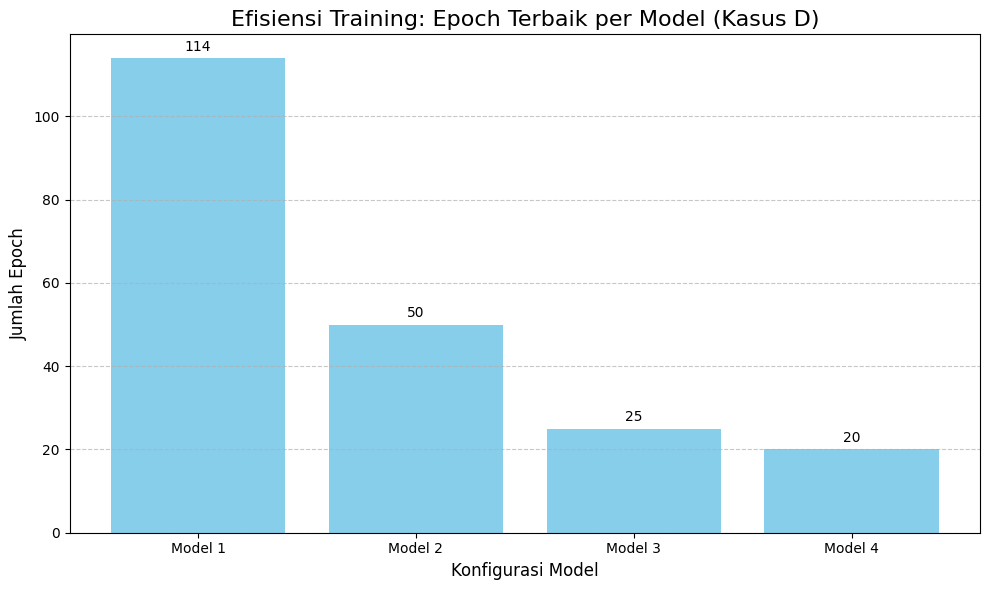

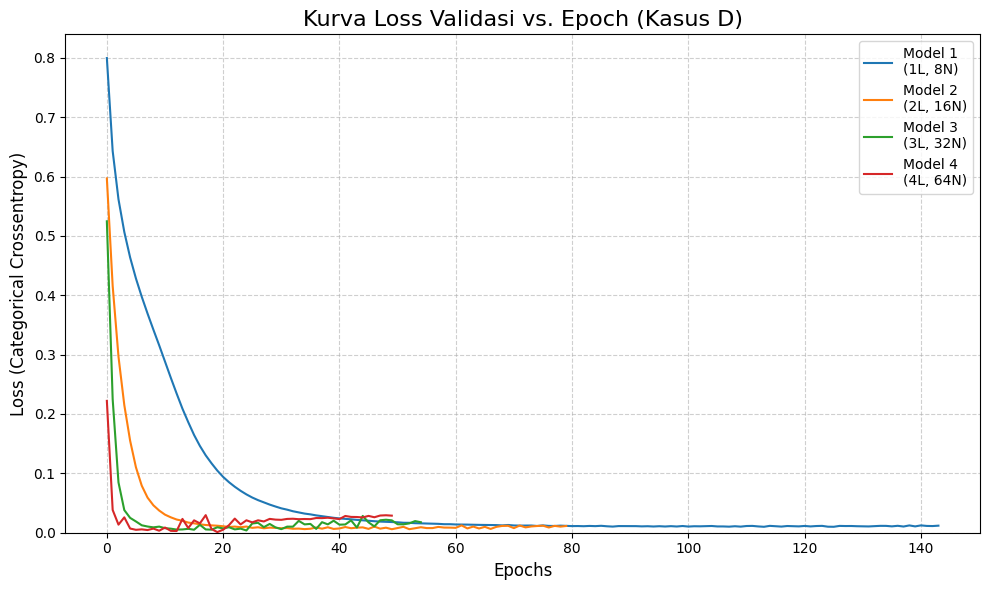

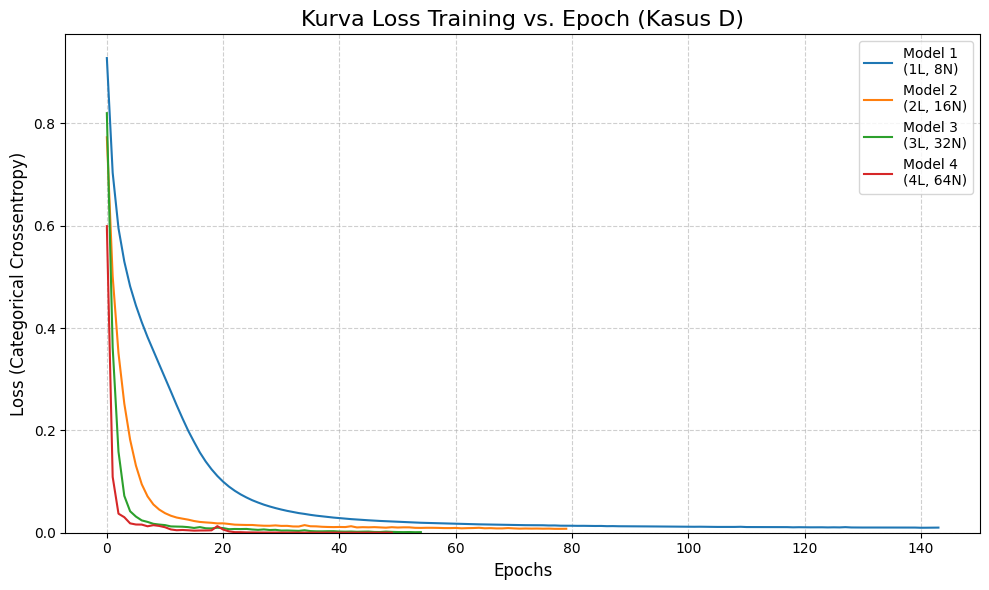

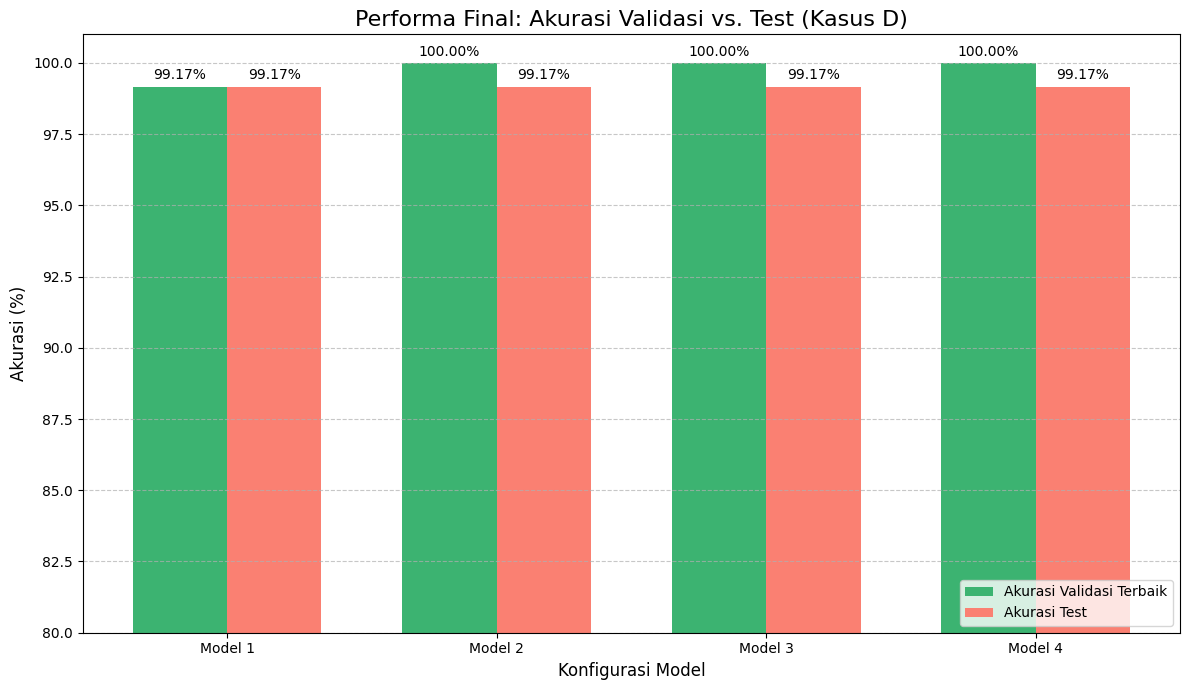

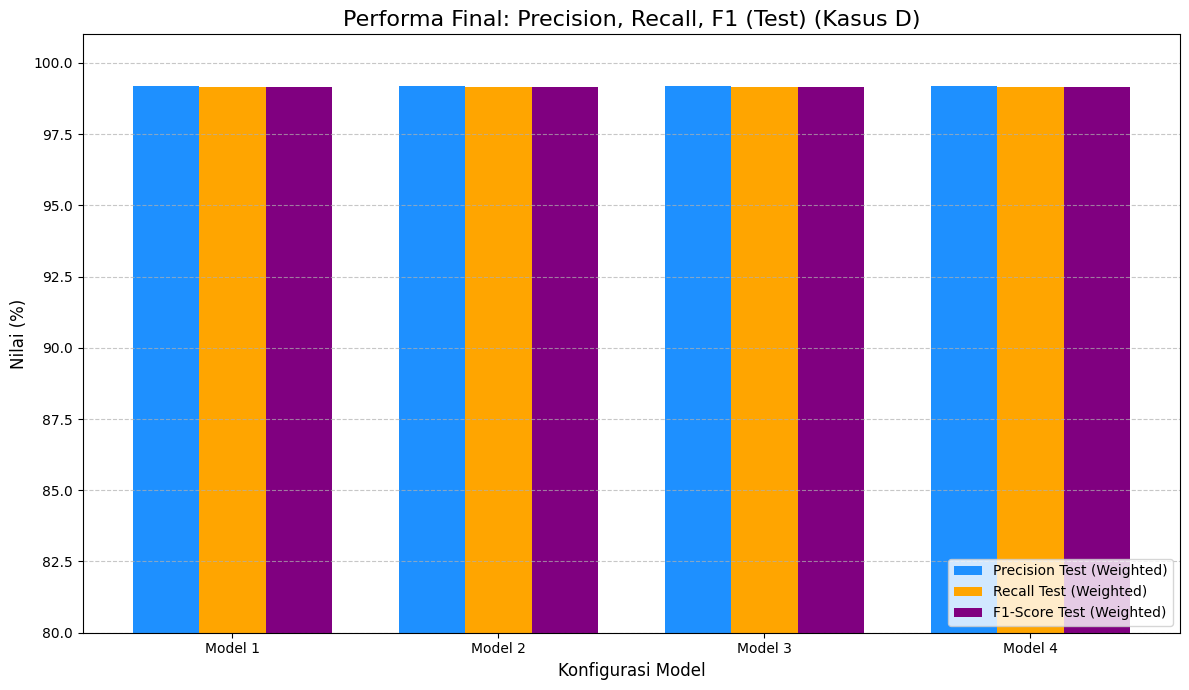


🏁 Visualisasi Selesai.



In [4]:
# Bagian ini dijalankan setelah Bagian 3 (Training) selesai

print("\n📊 Membuat 5 plot terpisah untuk menganalisis hasil Kasus D...\n")

# Buat label singkat untuk sumbu-x pada grafik batang
short_labels = [f'Model {i+1}' for i in range(len(model_configs))]
x_pos = np.arange(len(short_labels))
width = 0.35

#=============================================================================
# Plot 1: Grafik Batang Epoch Terbaik
#=============================================================================
plt.figure(figsize=(10, 6))
bars_epoch = plt.bar(short_labels, all_best_epochs, color='skyblue')
plt.title('Efisiensi Training: Epoch Terbaik per Model (Kasus D)', fontsize=16)
plt.ylabel('Jumlah Epoch', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar_label(bars_epoch, padding=3)
plt.tight_layout()
plt.show()

#=============================================================================
# Plot 2: Kurva Loss Validasi vs. Epoch
#=============================================================================
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_val_loss_histories):
    plt.plot(history, label=model_labels[i])
plt.title('Kurva Loss Validasi vs. Epoch (Kasus D)', fontsize=16)
plt.ylabel('Loss (Categorical Crossentropy)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

#=============================================================================
# Plot 3: Kurva Loss Training vs. Epoch
#=============================================================================
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_train_loss_histories):
    plt.plot(history, label=model_labels[i])
plt.title('Kurva Loss Training vs. Epoch (Kasus D)', fontsize=16)
plt.ylabel('Loss (Categorical Crossentropy)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

#=============================================================================
# Plot 4: Grafik Batang Perbandingan Akurasi Validasi vs Test
#=============================================================================
plt.figure(figsize=(12, 7))
rects1 = plt.bar(x_pos - width/2, [acc * 100 for acc in all_best_val_accuracies],
                 width, label='Akurasi Validasi Terbaik', color='mediumseagreen')
rects2 = plt.bar(x_pos + width/2, [acc * 100 for acc in all_test_accuracies],
                 width, label='Akurasi Test', color='salmon')

plt.title('Performa Final: Akurasi Validasi vs. Test (Kasus D)', fontsize=16)
plt.ylabel('Akurasi (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.bar_label(rects1, padding=3, fmt='%.2f%%')
plt.bar_label(rects2, padding=3, fmt='%.2f%%')
plt.ylim(80, 101)  # Agar terlihat jelas kalau ada gap kecil
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#=============================================================================
# Plot 5: Grafik Batang Precision, Recall, F1 (Test)
#=============================================================================
plt.figure(figsize=(12, 7))
bar_width = 0.25
plt.bar(x_pos - bar_width, [p * 100 for p in all_precisions],
        bar_width, label='Precision Test (Weighted)', color='dodgerblue')
plt.bar(x_pos, [r * 100 for r in all_recalls],
        bar_width, label='Recall Test (Weighted)', color='orange')
plt.bar(x_pos + bar_width, [f * 100 for f in all_f1s],
        bar_width, label='F1-Score Test (Weighted)', color='purple')

plt.title('Performa Final: Precision, Recall, F1 (Test) (Kasus D)', fontsize=16)
plt.ylabel('Nilai (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.ylim(80, 101)  # biar selaras dengan plot akurasi
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n🏁 Visualisasi Selesai.\n")

In [5]:
# Bagian ini dijalankan setelah Bagian 2 (Persiapan Data)

print("\n🚀 Mengekspor keseluruhan data uji Kasus D ke format C array (.h)...")

#=============================================================================
# Konfigurasi Ekspor
#=============================================================================
# Nama file header yang akan dibuat
output_header_path = 'test_data_kasus_d.h'

# Mengambil seluruh data uji dari variabel yang sudah ada
x_test_to_export = x_test
# --- PERUBAHAN PENTING ---
# Mengubah y_test dari format One-Hot Encoding kembali ke label tunggal (0, 1, 2)
y_test_to_export = np.argmax(y_test, axis=1)
# -------------------------

# Mendapatkan parameter secara dinamis dari data
num_test_samples = len(x_test_to_export)
num_features = x_test_to_export.shape[1]

#=============================================================================
# Fungsi untuk memformat array NumPy menjadi string C
#=============================================================================
def format_array_to_c(array, var_name, var_type='float'):
    c_string = f"const {var_type} {var_name}[] = {{"
    flat_array = array.flatten()
    # Format angka dengan presisi untuk float, atau sebagai integer
    formatted_values = [f"{val:.8f}f" if var_type == 'float' else str(int(val)) for val in flat_array]
    c_string += ", ".join(formatted_values)
    c_string += "};"
    return c_string

#=============================================================================
# Proses Pembuatan File Header
#=============================================================================
# Format array fitur (x_test) menjadi string C
c_features_array = format_array_to_c(x_test_to_export, "test_features_d", "float")

# Format array label (y_test) menjadi string C
c_labels_array = format_array_to_c(y_test_to_export, "test_labels_d", "int")

# Gabungkan semua menjadi satu file header
header_content = f"""
// File ini berisi {num_test_samples} sampel data uji untuk Kasus D (Klasifikasi Multikelas)
// Digunakan untuk validasi dan pengujian performa pada perangkat keras
#ifndef TEST_DATA_KASUS_D_H
#define TEST_DATA_KASUS_D_H

const int TEST_SAMPLES_COUNT_D = {num_test_samples};
const int FEATURES_PER_SAMPLE_D = {num_features};

// Data Fitur Uji (diratakan menjadi array 1D)
// Fitur telah melalui proses penskalaan (StandardScaler)
{c_features_array}

// Data Label Sebenarnya (Ground Truth): 0=setosa, 1=versicolor, 2=virginica
{c_labels_array}

#endif // TEST_DATA_KASUS_D_H
"""

# Tulis ke file .h
with open(output_header_path, 'w') as f:
    f.write(header_content)

print(f"✅ Data uji berhasil diekspor ke file C header: '{output_header_path}'")
print(f"   File tersebut berisi {num_test_samples} sampel data uji.")


🚀 Mengekspor keseluruhan data uji Kasus D ke format C array (.h)...
✅ Data uji berhasil diekspor ke file C header: 'test_data_kasus_d.h'
   File tersebut berisi 120 sampel data uji.


In [6]:
# Bagian ini dijalankan setelah Bagian 2 (Persiapan Data) karena memerlukan x_train

print("\n🚀 Membuat fungsi untuk representative dataset (Kasus D)...")

def representative_dataset_generator():
    """
    Generator yang menghasilkan sampel dari data latih (Kasus D).
    Data ini digunakan untuk kalibrasi selama proses kuantisasi INT8.
    """
    # Menggunakan 100 sampel acak dari data training sebagai data representatif
    num_samples = 100
    random_indices = np.random.choice(
        np.arange(len(x_train)), 
        size=num_samples, 
        replace=False
    )
    
    for i in random_indices:
        # Ambil satu sampel
        sample = x_train[i].reshape(1, x_train.shape[1])
        
        # Pastikan tipe data adalah float32 sebelum di-yield
        yield [sample.astype(np.float32)]

print("✅ Fungsi 'representative_dataset_generator' berhasil dibuat.")
print("   Fungsi ini siap digunakan untuk proses konversi model ke INT8.")


🚀 Membuat fungsi untuk representative dataset (Kasus D)...
✅ Fungsi 'representative_dataset_generator' berhasil dibuat.
   Fungsi ini siap digunakan untuk proses konversi model ke INT8.



🚀 Memulai pembuatan header dan pengumpulan data ukuran model untuk Kasus D...

Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpx_qnrgky'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 19), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2854542699472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854542698128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854542695632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854542702160: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Header FLOAT dibuat: headers_kasus_d_float/model_d_1_float.h (2.41 KB)
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmp_4kohfpi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 19), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Header INT8 dibuat: headers_kasus_d_int8/model_d_1_int8.h (2.20 KB)

Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmp2h79c98u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 19), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2854647610640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854647597776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854647610832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854647611216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650170256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650167568: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Header FLOAT dibuat: headers_kasus_d_float/model_d_2_float.h (4.56 KB)
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpiqbjzg2w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIO

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmppbqsbu0q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 19), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2854650180432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650181392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650178512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650180816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650182736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650182928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854650177936: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Header FLOAT dibuat: headers_kasus_d_float/model_d_3_float.h (13.56 KB)
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpx4j7qpxu'. The follow

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpbiun9efh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 19), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2854706920912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854706917264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854706916688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854706920528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854706917456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854708774672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854708773712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854708775056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854708775248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2854708775824: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Header FLOAT 

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


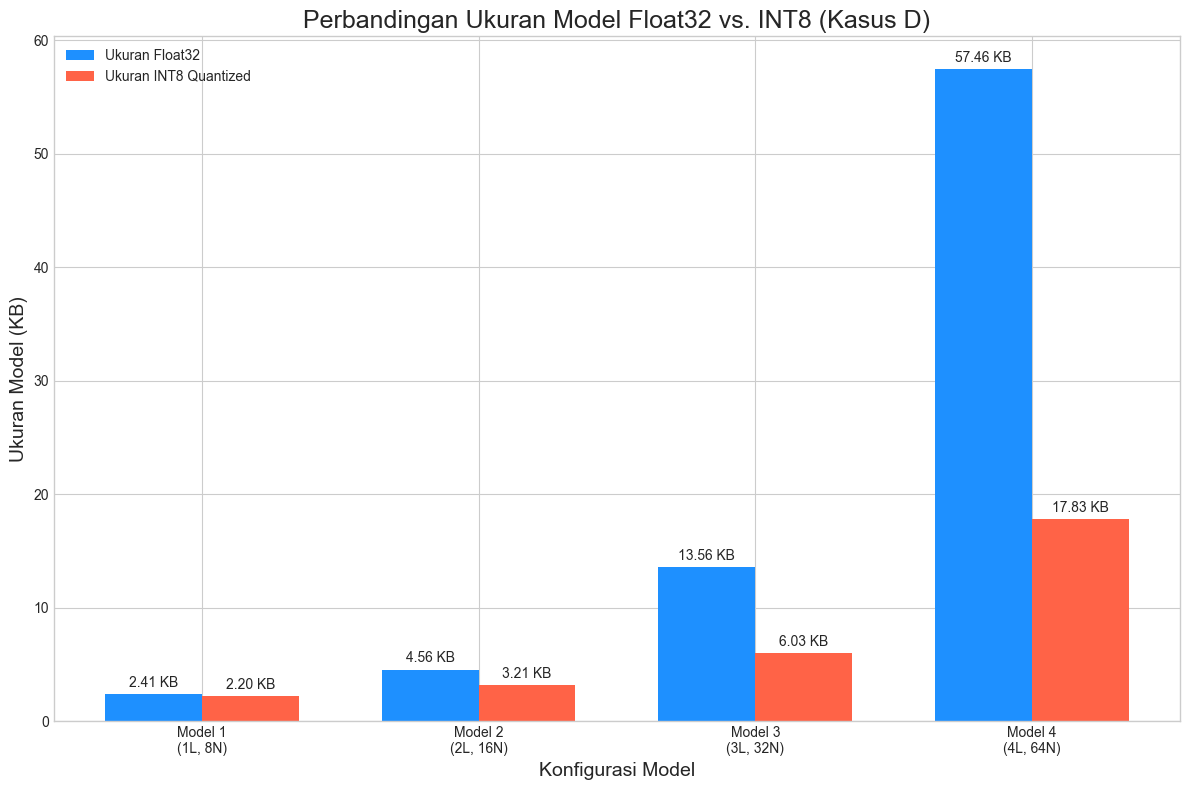


🏁 Alur kerja untuk Kasus D selesai.


In [7]:
# Bagian ini adalah langkah terakhir, dijalankan setelah semua bagian sebelumnya selesai

# 7.1 FUNGSI UNTUK KONVERSI KE HEADER C++
def convert_to_header(tflite_model, filename, model_name, description=""):
    hex_array = ','.join(f'0x{b:02x}' for b in tflite_model)
    c_var_name = f"g_{model_name.lower().replace(' ', '_').replace('-', '_')}"
    header = f'''// File ini dibuat secara otomatis
#ifndef {c_var_name.upper()}_H
#define {c_var_name.upper()}_H

// Model: {model_name}
// {description}
// Size: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)
const unsigned char {c_var_name}_model_data[] = {{{hex_array}}};
const unsigned int {c_var_name}_model_data_len = {len(tflite_model)};

#endif // {c_var_name.upper()}_H
'''
    with open(filename, 'w') as f:
        f.write(header)

# 7.2 Inisialisasi list khusus untuk plot ukuran
model_labels_plot = []
float_sizes = []
int8_sizes = []

print("\n🚀 Memulai pembuatan header dan pengumpulan data ukuran model untuk Kasus D...\n")

# 7.3 Loop utama untuk membuat header dan mengumpulkan ukuran
for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    
    # Buat label untuk plot di dalam loop
    label = f"Model {idx}\n({num_layers}L, {neurons}N)"
    model_labels_plot.append(label)
    
    # Path disesuaikan untuk Kasus D
    keras_model_path = f"saved_models_kasus_d/model_{idx}_{num_layers}L_{neurons}N.keras"
    model = tf.keras.models.load_model(keras_model_path)

    # --- PROSES FLOAT MODEL ---
    converter_float = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model_float = converter_float.convert()
    float_path = f"tflite_models_kasus_d_float/model_d_{idx}_float.tflite"
    with open(float_path, "wb") as f:
        f.write(tflite_model_float)
    
    header_path_float = f"headers_kasus_d_float/model_d_{idx}_float.h"
    model_name_f = f"Kasus D Model {idx} Float"
    desc_f = f"{num_layers}L, {neurons}N, float32"
    convert_to_header(tflite_model_float, header_path_float, model_name_f, desc_f)
    
    float_size_kb = len(tflite_model_float) / 1024
    float_sizes.append(float_size_kb)
    print(f"✅ Header FLOAT dibuat: {header_path_float} ({float_size_kb:.2f} KB)")

    # --- PROSES INT8 MODEL ---
    converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_int8.representative_dataset = representative_dataset_generator
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_int8.inference_input_type = tf.int8
    converter_int8.inference_output_type = tf.int8
    converter_int8._experimental_disable_per_channel_quantization_for_dense_layers = True

    tflite_model_int8 = converter_int8.convert()
    int8_path = f"tflite_models_kasus_d_int8/model_d_{idx}_int8.tflite"
    with open(int8_path, "wb") as f:
        f.write(tflite_model_int8)

    header_path_int8 = f"headers_kasus_d_int8/model_d_{idx}_int8.h"
    model_name_q = f"Kasus D Model {idx} INT8"
    desc_q = f"{num_layers}L, {neurons}N, int8 quantized"
    convert_to_header(tflite_model_int8, header_path_int8, model_name_q, desc_q)
    
    int8_size_kb = len(tflite_model_int8) / 1024
    int8_sizes.append(int8_size_kb)
    print(f"✅ Header INT8 dibuat: {header_path_int8} ({int8_size_kb:.2f} KB)\n")

# 7.4 Membuat plot perbandingan ukuran setelah loop selesai
print("\n📊 Membuat plot perbandingan ukuran model...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

x = np.arange(len(model_labels_plot))
width = 0.35

rects1 = plt.bar(x - width/2, float_sizes, width, label='Ukuran Float32', color='dodgerblue')
rects2 = plt.bar(x + width/2, int8_sizes, width, label='Ukuran INT8 Quantized', color='tomato')

plt.title('Perbandingan Ukuran Model Float32 vs. INT8 (Kasus D)', fontsize=18)
plt.ylabel('Ukuran Model (KB)', fontsize=14)
plt.xlabel('Konfigurasi Model', fontsize=14)
plt.xticks(x, model_labels_plot)
plt.legend()

plt.bar_label(rects1, padding=3, fmt='%.2f KB')
plt.bar_label(rects2, padding=3, fmt='%.2f KB')

plt.tight_layout()
plt.show()

print("\n🏁 Alur kerja untuk Kasus D selesai.")

In [8]:
# Bagian ini dijalankan setelah Bagian 7 (Konversi Model) selesai

print("\n🚀 Mengekstrak informasi kuantisasi dari setiap model INT8 Kasus D...\n")

# Loop melalui setiap model yang telah dikonversi ke INT8
for idx in range(1, len(model_configs) + 1):
    # Path disesuaikan untuk Kasus D
    quant_path = f"tflite_models_kasus_d_int8/model_d_{idx}_int8.tflite"
    
    # Buat interpreter untuk membaca model
    interpreter = tf.lite.Interpreter(model_path=quant_path)
    interpreter.allocate_tensors()

    # Dapatkan detail dari tensor input dan output
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Cetak informasi kuantisasinya
    print("="*50)
    print(f"📦 Info Kuantisasi untuk Model {idx} (Kasus D)")
    print("="*50)
    # quantization adalah tuple (scale, zero_point)
    print(f"🔹 Input scale      : {input_details['quantization'][0]}")
    print(f"🔹 Input zero point : {input_details['quantization'][1]}")
    print(f"🔹 Output scale     : {output_details['quantization'][0]}")
    print(f"🔹 Output zero point: {output_details['quantization'][1]}\n")

print("\n🏁 Ekstraksi Informasi Selesai.\n")


🚀 Mengekstrak informasi kuantisasi dari setiap model INT8 Kasus D...

📦 Info Kuantisasi untuk Model 1 (Kasus D)
🔹 Input scale      : 0.02855241857469082
🔹 Input zero point : -29
🔹 Output scale     : 0.00390625
🔹 Output zero point: -128

📦 Info Kuantisasi untuk Model 2 (Kasus D)
🔹 Input scale      : 0.020873166620731354
🔹 Input zero point : -24
🔹 Output scale     : 0.00390625
🔹 Output zero point: -128

📦 Info Kuantisasi untuk Model 3 (Kasus D)
🔹 Input scale      : 0.023148614913225174
🔹 Input zero point : -16
🔹 Output scale     : 0.00390625
🔹 Output zero point: -128

📦 Info Kuantisasi untuk Model 4 (Kasus D)
🔹 Input scale      : 0.03787701204419136
🔹 Input zero point : -53
🔹 Output scale     : 0.00390625
🔹 Output zero point: -128


🏁 Ekstraksi Informasi Selesai.

